In [45]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import List, Tuple, Union
from graphviz import Digraph
from math import exp

In [90]:
# @dataclass(frozen=True)
class Value:
    def __init__(self, data: float, prev: set=(), op: str='', grad: float=0.0, label: str='') -> None:
        self.data = data
        self.prev = set(prev)
        self.op = op
        self.grad = grad
        self.label = label
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Value) -> Value:
        other = Value(other) if isinstance(other, float) or isinstance(other, int) else other
        new_data = self.data + other.data
        op = '+'
        out = Value(data=new_data, prev=(self, other), op=op)
        # Defining the closure to compute the gradient
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # Assigning it to out's backward
        out._backward = _backward
        return out
    
    def __mul__(self, other: Union[Value, int, float]) -> Value:
        other = Value(other) if isinstance(other, float) or isinstance(other, int) else other
        new_data = self.data * other.data
        op = '*'
        out = Value(data=new_data, prev=(self, other), op=op)

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other: Union[int, float]) -> Value:
        return self.__mul__(other)
    
    def __radd__(self, other: Union[int, float]) -> Value:
        return self.__add__(other)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return self**-1 * other
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __pow__(self, other: Union[int, float]) -> Value:
        assert isinstance(other, (float, int)), "Only Int and Float powers are supported!"

        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += out.data * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self) -> Value:
        x = self.data
        t = (exp(2 * x) - 1) / (exp(2 * x) + 1)
        out = Value(t, prev=(self,), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return  out
    
    def exp(self) -> Value:
        x = self.data
        out = Value(exp(x), (self, ), "exp")

        def _backward():
            self.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topology: List[Value] = []
        visited = set()

        # Function to visit each child and add it to topology
        # (Topological Traversal of Directed Acyclic Graphs)
        def build_topology(node: Value):
            if node not in visited:
                visited.add(node)
                for child in node.prev:
                    build_topology(child)
                topology.append(node)
        
        # Build Topology
        build_topology(self)

        # Initialize the gradient
        self.grad = 1.0
        for node in reversed(topology):
            node._backward()



In [91]:
l = Value(9)
k = Value(5)
print(l-k)
print(k - 1)
print(-l)
print(l**.5)
print(l/k)
print(k/2)
print(10/k)
print(5 - k)

Value(data=4)
Value(data=4)
Value(data=-9)
Value(data=3.0)
Value(data=1.8)
Value(data=2.5)
Value(data=2.0)
Value(data=0)


In [55]:
def trace(root) -> Tuple[List[Value], List[tuple]]:
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v: Value):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root: Value):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [18]:
a = Value(3.0, label='a')
b = Value(5.0, label='b')
c = a + b; c.label = 'c'
d = Value(2.0, label='d')
e = d * c; e.label = 'e'

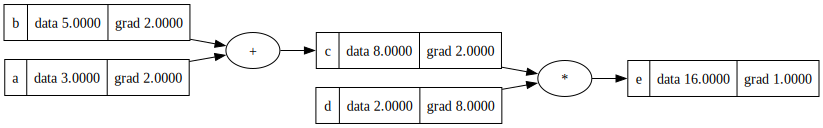

In [21]:
draw_dot(e)

In [20]:
e.backward()

[Value(data=2.0), Value(data=5.0), Value(data=3.0), Value(data=8.0), Value(data=16.0)]


In [7]:
def calculate_gradient():
    # Initializing values
    a = Value(3.0, label='a')
    b = Value(5.0, label='b')
    c = a + b; c.label = 'c'
    d = Value(2.0, label='d')
    e = d * c; e.label = 'e'

    h = 0.000000001

    # Calculating dd/de
    d1 = d.data + h # d1 = d+h
    e1 = d1 * c.data # f(d+h)
    print(f"de/dd = {(e1 - e.data)/h}") # de/dd = (f(d+h) - f(d))/h

    # Calculating dc/de
    c1 = c.data + h # c1 = c+h
    e1 = c1 * d.data # f(c+h)
    print(f"de/dc = {(e1 - e.data)/h}") # de/dc = (f(c+h) - f(c))/h

    # Calculating db/dc
    b1 = b.data + h # b1 = b+h
    c1 = b1 + a.data # f(b+h)
    print(f"dc/db = {(c1 - c.data)/h}") # dc/db = f(d)

calculate_gradient()

de/dd = 8.000000661922968
de/dc = 2.000000165480742
dc/db = 1.000000082740371


In [22]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.881373587019, label='b')

# Multiplying weights
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Adding the bias
Wx = x1w1 + x2w2; Wx.label = 'Wx'
z = Wx + b; z.label = 'z'
f_z = z.tanh(); f_z.label = 'o'

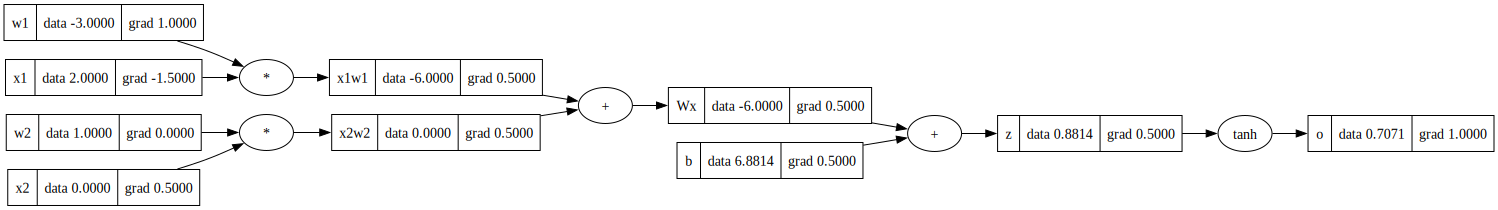

In [25]:
draw_dot(f_z)

In [24]:
f_z.backward()

[Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=6.881373587019), Value(data=0.8813735870189996), Value(data=0.7071067811862758)]


In [10]:
f_z.grad = 1.0

In [11]:
f_z._backward()
z._backward()
b._backward()
Wx._backward()
x1w1._backward()
x2w2._backward()

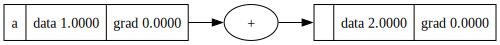

In [27]:
a = Value(1, label='a')
b = a + a
draw_dot(b)

[Value(data=1), Value(data=2)]


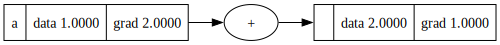

In [28]:
b.backward()
draw_dot(b)

## Building a Neuron

In [92]:
import random

class Neuron:
    def __init__(self, n_inputs) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        out = sum( (wi * xi for wi, xi in zip(self.w, x)), self.b)
        activated_out = out.tanh()
        return activated_out
    
    @property
    def parameters(self) -> List[Value]:
        return self.w + [self.b]

In [57]:
x = [2.0, 3.0]
neuron = Neuron(2)
neuron(x)

Value(data=-0.9907923459689248)

## Building a Layer

In [93]:
class Layer:
    def __init__(self, n_inputs, n_outpus) -> None:
        self.n_inputs = n_inputs
        self.neurons = [Neuron(n_inputs) for _ in range(n_outpus)]
    
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def __str__(self):
        return f"Layer({len(self.neurons)} neurons, n_inputs={self.n_inputs})"
    
    def __repr__(self):
        return f"Layer({len(self.neurons)} neurons, n_inputs={self.n_inputs})"
    
    @property
    def parameters(self) -> List[Value]:
        return [p for neuron in self.neurons for p in neuron.parameters]

In [59]:
x = [3.0, 4.0, 5.0, 1.0]
layer  = Layer(n_inputs=4, n_outpus=1)
layer(x)

Value(data=-0.9997578900220631)

In [60]:
layer

Layer(1 neurons, n_inputs=4)

## Building a MLP

In [207]:
class MLP:
    def __init__(self, n_inputs: int, layers: List[int]) -> None:
        layers_with_input = [n_inputs] + layers
        self.layers = [Layer(layers_with_input[i], layers_with_input[i+1]) for i in range(len(layers))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __str__(self) -> str:
        _str = ""
        for layer in self.layers:
            _str += f"{layer}\n"
        return _str
    
    def __repr__(self) -> str:
        _str = ""
        for layer in self.layers:
            _str += f"{layer}\n"
        return _str
    
    @property
    def parameters(self) -> List[Value]:
        return [p for layer in self.layers for p in layer.parameters]

In [206]:
model = MLP(3, [4, 3, 1])
model

Layer(4 neurons, n_inputs=3)
Layer(3 neurons, n_inputs=4)
Layer(1 neurons, n_inputs=3)

In [208]:
model = MLP(3, [5, 4, 1])
X = [[2.0, 3.0, -1.0],
     [3.0, -1.0, 0.5],
     [0.5, 1.0, 1.0],
     [1.0, 1.0, -1.0]]
Y = [1.0, -1.0, -1.0, 1.0]

In [200]:
learning_rate = 0.1
NUM_EPOCHS = 1

for i in range(NUM_EPOCHS):
    # Forward Pass
    Y_hat = [model(x) for x in X]

    # Calculate Loss per sample
    loss = [(y - y_hat)**2 for y, y_hat in zip(Y, Y_hat)]

    # Calculate the cost
    cost = sum(loss)

    # Clear residual Gradients
    for p in model.parameters:
        p.grad = 0.0

    # The Magic !!! Backpropagation ✨
    cost.backward()

    

# for layer in model.layers:
#     print("_______________________________________")
#     print(f"Visiting {layer}")
#     print("---------------------------------------")
#     for neuron in layer.neurons:
#         print(f"|-> Visiting {neuron}")
#         for weight in neuron.w:
#             print(f"\t|-> Updating {weight}")
#             weight = weight - learning_rate * weight.grad
#         print(f"\t|-> Updating bias...")
#         neuron.b = neuron.b - learning_rate * neuron.b.grad
#     print()

[Value(data=-0.0868688539841419),
 Value(data=0.1582539651762508),
 Value(data=-0.2852301664416002),
 Value(data=0.07233698522730315)]